# Projecting Population Growth

*Modeling and Simulation in Python*

Copyright 2021 Allen Downey

License: [Creative Commons Attribution-NonCommercial-ShareAlike 4.0 International](https://creativecommons.org/licenses/by-nc-sa/4.0/)

In [1]:
!pip install lxml

In [2]:
# import functions from modsim

from modsim import *

In [3]:
filename = 'World_population_estimates.html'
tables = pd.read_html(filename, header=0, index_col=0, decimal='M')
table2 = tables[2]
table2.columns = ['census', 'prb', 'un', 'maddison', 
                  'hyde', 'tanton', 'biraben', 'mj', 
                  'thomlinson', 'durand', 'clark']

In [4]:
un = table2.un / 1e9
census = table2.census / 1e9

And here are the functions from the previous chapter.

In [5]:
def run_simulation(system, growth_func):
    results = TimeSeries()
    results[system.t_0] = system.p_0
    
    for t in range(system.t_0, system.t_end):
        growth = growth_func(t, results[t], system)
        results[t+1] = results[t] + growth
        
    return results

In [6]:
#from chap06 import run_simulation

def plot_estimates():
    census.plot(style=':', label='US Census')
    un.plot(style='--', label='UN DESA')
    decorate(xlabel='Year', 
             ylabel='World population (billions)') 

In the previous chapter we developed a quadratic model of world
population growth from 1950 to 2016. It is a simple model, but it fits
the data well and the mechanisms it's based on are plausible.

In this chapter we'll use the quadratic model to generate projections of future growth, and compare our results to projections from actual
demographers.

## Generating Projections

Let's run the quadratic model, extending the results until 2100, and see how our projections compare to the professionals'.

Here's the quadratic growth function again.

In [7]:
def growth_func_quad(t, pop, system):
    return system.alpha * pop + system.beta * pop**2

And here are the system parameters.

In [64]:
t_0 = census.index[0]
p_0 = census[t_0]

system = System(t_0 = t_0,
                p_0 = p_0,
                alpha = 25 / 1000,
                beta = -1.8 / 1000,
                t_end = 2100)

With `t_end=2100`, we can generate the projection by calling `run_simulation` the usual way.

In [65]:
results = run_simulation(system, growth_func_quad)

Here are the last few values in the results.

In [66]:
show(results.tail())

,Quantity
Time,
2096,12.462519
2097,12.494516
2098,12.525875
2099,12.556607
2100,12.586719


Here's what the results look like.

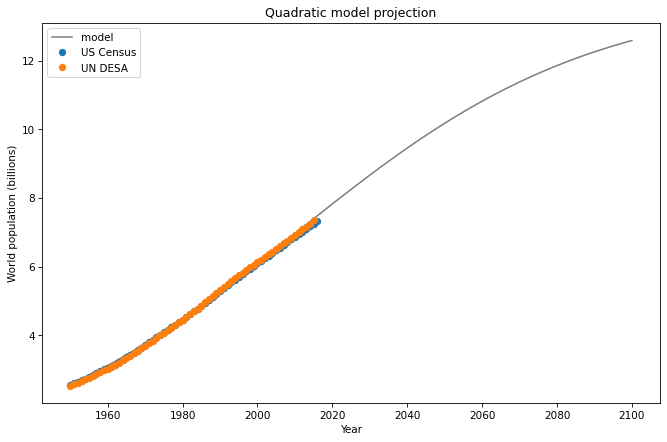

In [67]:
results.plot(color='gray', label='model')
plt.plot(census, 'o', label='US Census')
plt.plot(un, 'o', label='UN DESA')
decorate(xlabel='Year', 
         ylabel='World population (billions)',
         title='Quadratic model projection')

According to the model, population growth will slow gradually after 2020, approaching 12.6 billion by 2100 (and a bit less than 14 billion by 2200).  But the model does not capture the projected slow down in growth rate that is expected to occur in the next 50-100 years.

The model projections are substantially higher than the estimates from the US Census and the UN DESA.  But before we conclude that the model is wrong, let's think about what it means to compare a model to data.

In general, a model is useful if it provides a good match to the data it is designed to fit, and if it successfully predicts values in the future.  But it is not always possible to meet both of these goals.

In this case, the model is based on a quadratic function, which is a good description of the data from 1950 to 2016.  But it is not a good description of the data before 1950, and it is probably not a good model for projecting into the future.

I am using the word *projection* deliberately, rather than
*prediction*, with the following distinction: "prediction" implies
something like "this is what we expect to happen, at
least approximately"; "projection" implies something like "if this
model is a good description of the system, and if nothing in the future causes the system parameters to change, this is what would happen."

Using "projection" leaves open the possibility that there are important things in the real world that are not captured in the model. It also suggests that, even if the model is good, the parameters we estimate based on the past might be different in the future.

The quadratic model we've been working with is based on the assumption
that population growth is limited by the availability of resources; in
that scenario, as the population approaches carrying capacity, birth
rates fall and death rates rise because resources become scarce.

If that assumption is valid, we might be able to use actual population
growth to estimate carrying capacity, provided we observe the
transition into the population range where the growth rate starts to fall.

But in the case of world population growth, those conditions don't
apply. Over the last 50 years, the net growth rate has leveled off, but not yet started to fall, so we don't have enough data to make a credible estimate of carrying capacity. And resource limitations are probably *not* the primary reason growth has slowed. As evidence, consider:

-   First, the death rate is not increasing; rather, it has declined
    from 1.9% in 1950 to 0.8% now (see <http://modsimpy.com/mortality>).
    So the decrease in net growth is due entirely to declining birth
    rates.

-   Second, the relationship between resources and birth rate is the
    opposite of what the model assumes; as nations develop and people
    become more wealthy, birth rates tend to fall.

We should not take too seriously the idea that this model can estimate
carrying capacity. But the predictions of a model can be credible even
if the assumptions of the model are not strictly true. For example,
population growth might behave *as if* it is resource limited, even if
the actual mechanism is something else.

In fact, demographers who study population growth often use models
similar to ours. In the next section, we'll compare our projections to
theirs.

## Comparing Projections

From the same Wikipedia page where we got the past population estimates, we'll read `table3`, which contains projections for population growth over the next 50-100 years, generated by the U.S. Census, U.N. DESA, and the Population Reference Bureau.

In [68]:
table3 = tables[3]

The column names are long strings; for convenience, I'll replace them with abbreviations.

In [69]:
table3.columns = ['census', 'prb', 'un']

Here are the first few rows:

In [70]:
table3.head()

,census,prb,un
Year,,,
2016,7.334772e+09,NaN,7.432663e+09
2017,7.412779e+09,NaN,NaN
2018,7.490428e+09,NaN,NaN
2019,7.567403e+09,NaN,NaN
2020,7.643402e+09,NaN,7.758157e+09


Some values are `NaN`, which indicates missing data, because some organizations did not publish projections for some years.
The following function plots projections from the U.N. DESA and U.S. Census.  It uses `dropna` to remove the `NaN` values from each series before plotting it.

In [71]:
def plot_projections(table):
    """Plot world population projections.
    
    table: DataFrame with columns 'un' and 'census'
    """
    census_proj = table.census.dropna() / 1e9
    un_proj = table.un.dropna() / 1e9
    
    census_proj.plot(style=':', label='US Census')
    un_proj.plot(style='--', label='UN DESA')
    
    decorate(xlabel='Year', 
             ylabel='World population (billions)')

Here are the professional projections compared to the results of the quadratic model.

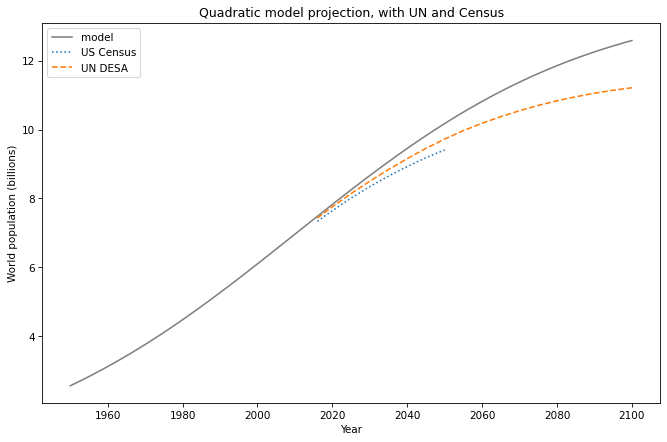

In [72]:
results.plot(color='gray', label='model')
plot_projections(table3)
decorate(title='Quadratic model projection, with UN and Census')

The U.N. DESA expects the world population to reach 11 billion around 2100, and then level off.
Projections by U.S. Census are a little lower, and they only go until 2050.



## Summary

In this chapter we use the quadratic growth model to project world population growth between now and 2100.

Real demographers expect world population to grow more slowly than our model, probably because their models are broken down by region and country, where conditions are different, and they take into account expected economic development.

Nevertheless, their projections are qualitatively similar to ours, and
theirs differ from each other almost as much as they differ from ours.
So the results from the model, simple as it is, are not entirely unreasonable.

If you are interested in some of the factors that go into the professional projections, you might like this video by Hans Rosling about the demographic changes we expect this century: <https://www.youtube.com/watch?v=ezVk1ahRF78>.

This chapter is available as a Jupyter notebook where you can read the text, run the code, and work on the exercises. 
You can access the notebooks at <https://allendowney.github.io/ModSimPy/>.

The net growth rate of world population has been declining for several decades.  That observation suggests one more way to generate more realistic projections, by extrapolating observed changes in growth rate.

To compute past growth rates, we'll use a function called `diff`, which computes the difference between successive elements in a `Series`.  For example, here are the changes from one year to the next in `census`:

In [73]:
diff = census.diff()
show(diff.head())

,census
Year,
1950,NaN
1951,0.037311
1952,0.041832
1953,0.045281
1954,0.048175


The first element is `NaN` because we don't have the data for 1949, so we can't compute the first difference.

If we divide these differences by the populations, the result is an estimate of the growth rate during each year: 

In [74]:
alpha = census.diff() / census
show(alpha.head())

,census
Year,
1950,NaN
1951,0.014378
1952,0.015865
1953,0.016883
1954,0.017645


The following function computes and plots the growth rates for the `census` and `un` estimates:

In [75]:
def plot_alpha():
    alpha_census = census.diff() / census
    alpha_census.plot(style='.', label='US Census')

    alpha_un = un.diff() / un
    alpha_un.plot(style='.', label='UN DESA')

    decorate(xlabel='Year', ylabel='Net growth rate')

It uses `style='.'` to plot each data point with a small circle.
And here's what it looks like.

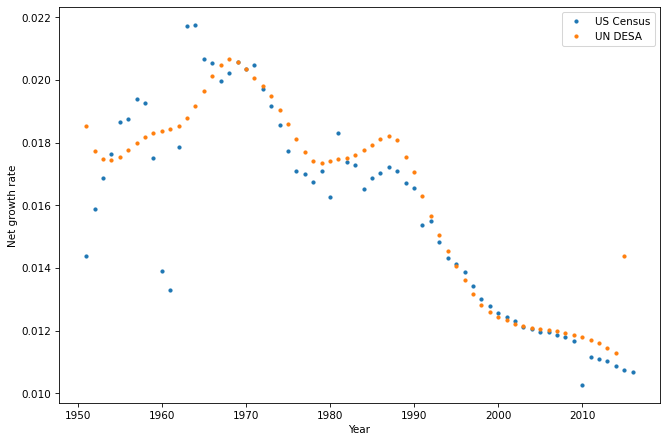

In [76]:
plot_alpha()

Other than a bump around 1990, the net growth rate has been declining roughly linearly since 1970.

We can model the decline by fitting a line to this data and extrapolating into the future.
Here's a function that takes a time stamp and computes a line that roughly fits the growth rates since 1970.

In [77]:
def alpha_func(t):
    intercept = 0.02
    slope = -0.00021
    return intercept + slope * (t - 1970)

import numpy as np

def alpha_func_exp(t):
    intercept = 0.02
    slope = -0.016
    return intercept * np.exp(slope * (t - 1970))

To see what it looks like, I'll create an array of time stamps from 1960 to 2040 and use `alpha_func` to compute the corresponding growth rates.

In [80]:
t_array = linspace(1960, 2040, 5)
alpha_array = alpha_func(t_array)
alpha_array_exp = alpha_func_exp(t_array)

Here's what it looks like, compared to the data.

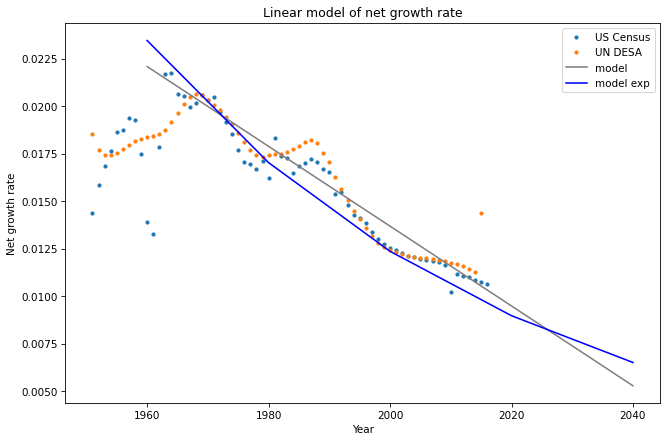

In [81]:
from matplotlib.pyplot import plot

plot_alpha()
plot(t_array, alpha_array, label='model', color='gray')
plot(t_array, alpha_array_exp, label='model exp', color='blue')
decorate(ylabel='Net growth rate',
         title='Linear model of net growth rate')

If you don't like the `slope` and `intercept` I chose, feel free to adjust them.

Now, as an exercise, you can use this function to project world population until 2100.

1. Create a `System` object that includes `alpha_func` as a system parameter.

2. Define a growth function that uses `alpha_func` to compute the net growth rate at the given time `t`.

3. Run a simulation from 1960 to 2100 with your growth function, and plot the results.

4. Compare your projections with those from the US Census and UN.


We will actually use five different growth function models.  The first is the constant growth model, which we have already implemented.

We have seen a linear model above, but we will implement it here with a few different assumptions:

Model 2: Linear model of net growth rate (v1)
    a) Before 1970, assume a constant growth rate of 2% per year.
    b) After 1970, if the net growth rate is negative, return 0, otherwise, return the product of the linear fit to the net growth rate above and the current population.
    
Model 3: Linear model of net growth rate (v2)
    a) Before 1970, assume a constant growth rate of 2% per year.
    b) After 1970, return the product of the linear fit to the net growth rate above and the current population.
    
Model 4: Linear model of net growth rate (v3)
    a) Return the product of the linear fit to the net growth rate above and the current population.
    
Model 5: Exponential model of net growth rate
    a) Before 1970, assume a constant growth rate of 2% per year.
    b) After 1970, if the net growth rate is negative, return 0, otherwise, return the product of the exponential fit to the net growth rate above and the current population.
    


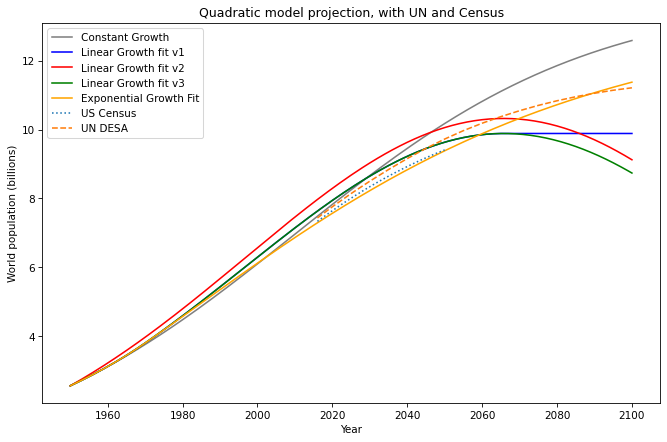

In [82]:
t_0 = census.index[0]
p_0 = census[t_0]


system = System(t_0 = t_0,
                p_0 = p_0,
                alpha = 25 / 1000,
                alpha_func = alpha_func,
                beta = -1.8 / 1000,
                t_end = 2100)

def growth_func1(t, pop, system):

    """ Computes the population next year using a fit to the net growth rate. Before 1970, we assume a constant growth rate of 2% per year.  After that, if the net growth rate is negative, we return 0, otherwise, we return the product of the linear fit to the net growth rate above and the current population."""

    if t < 1970:
        local_alpha =  0.02
    else:
        if alpha_func(t) < 0.0:
            local_alpha = 0.0
        else:
            local_alpha = alpha_func(t)

    # print(t, system.alpha, system.alpha_func(t), local_alpha)

    return  local_alpha * pop

def growth_func2(t, pop, system):
    
    """ Computes the population next year using a linear fit to the net growth rate."""

    local_alpha = alpha_func(t)

    # print(t, system.alpha, system.alpha_func(t), local_alpha)

    return  local_alpha * pop

def growth_func3(t, pop, system):
    
    """ Computes the population next year using a fit to the net growth rate. Before 1970, we assume a constant growth rate of 2% per year.  After that, we return the product of the linear fit to the net growth rate above and the current population."""

    if t < 1970:
        local_alpha =  0.02
    else:
        local_alpha = alpha_func(t)

    # print(t, system.alpha, system.alpha_func(t), local_alpha)

    return  local_alpha * pop

def growth_func4(t, pop, system):
    
    """ Computes the population next year using a fit to the net growth rate. Before 1970, we assume a constant growth rate of 2% per year.  After that, we return the product of the exponential fit to the net growth rate above and the current population."""

    if t < 1970:
        local_alpha =  0.02
    else:
        local_alpha = alpha_func_exp(t)

    # print(t, system.alpha, system.alpha_func(t), local_alpha)

    return  local_alpha * pop

results_new1 = run_simulation(system, growth_func1)
results_new2 = run_simulation(system, growth_func2)
results_new3 = run_simulation(system, growth_func3)
results_new4 = run_simulation(system, growth_func4)

results.plot(color='gray', label='Constant Growth')
results_new1.plot(color='blue', label='Linear Growth fit v1')
results_new2.plot(color='red', label='Linear Growth fit v2')
results_new3.plot(color='green', label='Linear Growth fit v3')
results_new4.plot(color='orange', label='Exponential Growth Fit')

#plot_estimates()
plot_projections(table3)
decorate(title='Quadratic model projection, with UN and Census')

In [25]:
# Solution goes here

In [26]:
# Solution goes here

In [27]:
# Solution goes here

In [28]:
# Solution goes here

In [29]:
# Solution goes here

In [30]:
# Solution goes here

In [31]:
# Solution goes here